In [416]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy import interpolate
from scipy import integrate
%matplotlib inline
from __future__ import division

## Matriz de Overlap

In [186]:
# Elemento de matriz de overlap
def Overlap_ij(alpha,i,j):
    Sij = ( np.pi / (alpha[i] + alpha[j]) )**(1.5)
    return Sij

# Matriz de overlap
def Matriz_Overlap(alpha):
    nsize = len(alpha)
    S = np.zeros((nsize,nsize))
    for i in range(0,nsize):
        for j in range(i,nsize):        
            S[i,j]=Overlap_ij(alpha,i,j)
            S[j,i]=S[i,j]
    return S

## Matriz del Hamiltoniano

In [187]:
# Elemento de matriz de cinetica
def Tij(alpha,l,i,j):
    rnum = 3 * np.pi**(1.5) * alpha[i] * alpha[j]
    rden = (alpha[i] + alpha[j])**(2.5)    
    Tij = rnum/rden + l*(l+1)*np.pi**(3/2)/(alpha[i]+alpha[j])**0.5
    return Tij

 
# Elemento de matriz de potencial
def Vij(alpha,Z,i,j):
    Vij =  Z*( -2*np.pi )  /  (alpha[i] + alpha[j])    
    return Vij

# Matriz del Hamiltoniano en la base elegida (gaussianos en este caso)
def Matriz_H(alpha,l,Z):
    nsize = len(alpha)
    H = np.zeros((nsize,nsize))
    for i in range(nsize):
        for j in range(i,nsize): 
            H[i,j] = Tij(alpha,l,i,j) + Vij(alpha,Z,i,j)
            H[j,i] = H[i,j]
    return H

## Tensor Q (integrales de 4 gaussianas con diferentes exponentes)

In [188]:
# Elemento de matriz del tensor Q, donde p,r,q,s son las combinaciones de los alphas
def Qprqs(alpha,p,r,q,s):
    num = 2*np.pi**2.5 
    den = (alpha[p]+alpha[q])*(alpha[r]+alpha[s])*(alpha[p]+alpha[q]+alpha[r]+alpha[s])**0.5
    return num/den

# Tensor Q
def Tensor_Q(alpha):
    Iter = range(len(alpha))
    Q = np.array([[[[Qprqs(alpha,p,r,q,s) for p in Iter] for r in Iter] for q in Iter] for s in Iter])
    return Q

## Matriz del operador de Fock

In [189]:
# Construccion del operador de Fock en forma matricial
def F_Matriz(H,Q,Ci):
    size = H.shape[0]
    F = np.zeros(H.shape)
    for i in range(size):
        for j in range(i,size):
            F[i,j] = H[i,j] + Ci.dot(Q[i,:,j,:].dot(Ci))
            F[j,i] = F[i,j]
    return F

## Normalizacion de los coeficientes (via matriz de overlap)

In [190]:
def C_Norm(C,S):
    size = C.shape[0]
    for i in range(size):
        Ci = C[:,i]
        norm = Ci.T.dot(S.dot(Ci))**0.5
        C[:,i] = C[:,i]/norm

## Calculo de la energia de Hartree-Fock

In [191]:
def Energy_Calc(Ci,H,Q):
    Iter = range(Ci.shape[0])
    cumres = 2*Ci.T.dot(H.dot(Ci))
    for p in Iter:
        for r in Iter:
            for q in Iter:
                for s in Iter:
                    cumres = cumres + Ci[p]*Ci[r]*Ci[q]*Ci[s]*Q[p,r,q,s]
    return cumres

## Calculo de la funcion de onda de HF a partir de los coeficientes

In [192]:
def psi(Ci,Alpha,x):
    nsize = len(Ci) 
    res = 0
    for i in range(0,nsize):
        res = res + Ci[i]*np.exp(-Alpha[i]*x**2)
    return res

# He $1s^2$

In [451]:
# H
#alpha = np.array([0.1219492,0.444529,1.962079,13.00773])

# H- 
#alpha = 0.15*np.array([0.298073,1.242567,5.782948,38.474970])

# He
#1s2
alpha = np.array([0.298073,1.242567,5.782948,38.474970])
#2s2
#alpha = np.array([0.006,0.05, 0.1, 0.298073,1.242567,5.782948,38.474970])

# Li+
#alpha = 3*np.array([0.298073,1.242567,5.782948,38.474970])


Z = 2
l = 0

S = Matriz_Overlap(alpha)
C_new = np.random.rand(len(alpha),len(alpha)) #np.ones((len(alpha),len(alpha)))
C_Norm(C_new,S)

H = Matriz_H(alpha,l,Z)
Q = Tensor_Q(alpha)

cont = 0

In [458]:
C = C_new
F = F_Matriz(H,Q,C[:,0])
E, C_new = eigh(F,S,type=1)
C_Norm(C_new,S)
print "Iteracion Nro:", cont
print "-) Energia Total:", Energy_Calc(C_new[:,0],H,Q)
print "-) Energia Ionizacion:", E[0]
cont += 1

Iteracion Nro: 4
-) Energia Total: -2.855160379963242
-) Energia Ionizacion: -0.9140678141374324


- La energia total y la de ionizacion dan razonable con lo que se ve en las tablas de Bunge y Johnson

In [459]:
r,psiFunc = np.loadtxt("He_wave.1s",unpack=True)
rmin, rmax = 0, 10
r = r[np.where(r<=rmax)]
psi_johnson = psiFunc[:len(r)]
psi_calc = np.zeros(len(r))
psi_calc = psi(C_new[:,0],alpha,r)

# Normalizo ambas funciones en el intervalo deseado
psi_johnson = psi_johnson/np.trapz((psi_johnson)**2,x=r)**0.5
psi_calc = psi_calc/np.trapz((r*psi_calc)**2,x=r)**0.5

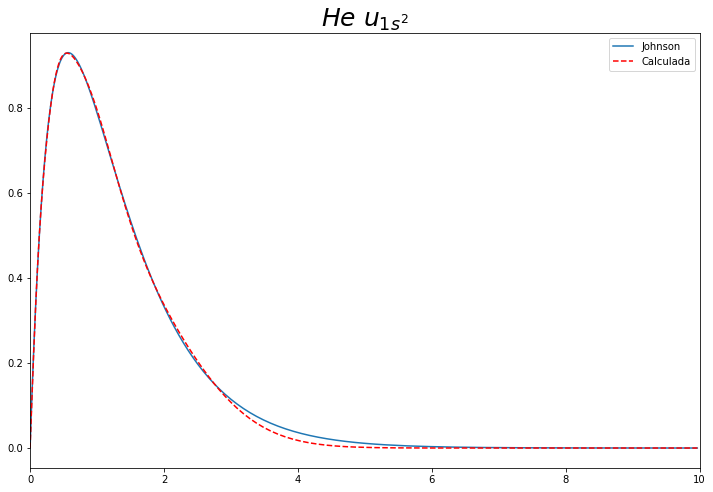

In [460]:
plt.figure(figsize=(12,8))
plt.plot(r,psi_johnson, label = "Johnson")
plt.plot(r,r*psi_calc ,'r--', label = "Calculada")
plt.xlim(rmin,rmax)
plt.title("$He$ $u_{1s^2}$", size=25)
plt.legend(loc='best')

## Valores medios de r

In [467]:
r_2Mean = np.trapz(psi_calc**2*r**4,r)
r_Mean = np.trapz(psi_calc**2*r**3,r)
r_m1Mean = np.trapz(psi_calc**2*r,r)
r_m2Mean = np.trapz(psi_calc**2,r)
print "<r^2> =",r_2Mean
print "<r> =",r_Mean
print "<r^(-1)> =",r_m1Mean
print "<r^(-2)> =",r_m2Mean

<r^2> = 1.1625384921523685
<r> = 0.9233115871430844
<r^(-1)> = 1.6843127314813695
<r^(-2)> = 5.862649328469004


- OK con tablas de Bunge, aunque se ven diferencias en la primera cifra significativa en $r^2$ y en $\frac{1}{r^2}$, pero me parecieron razonables considerando que la funcion de onda que obtuve no solapa completamente con la de Johnson. Probe hacer Simpson para mejorar el metodo de integracion, pero no mejora mucho el resultado.

## Virial

In [465]:
# Calculo el potencial interelectronico
Vinter = 0
Ci = C_new[:,0]
Iter = range(len(Ci))
for p in Iter:
    for t in Iter:
        for q in Iter:
            for s in Iter:
                Vinter = Vinter + Ci[p]*Ci[t]*Ci[q]*Ci[s]*Q[p,t,q,s]
                
# Cinetica
T = np.trapz(-np.gradient(np.gradient(r*psi_calc,r),r)*psi_calc*r,r)
# Potencial
V = np.trapz(-4*psi_calc**2*r,r) + Vinter
print "Cinetica =",T
print "Potencial =",V
print "Energia Total=",T+V
print "<V>/<T> =",V/T

Cinetica = 2.856551609579858
Potencial = -5.710367967803121
Energia Total= -2.8538163582232627
<V>/<T> = -1.9990424638758766


- OK con tablas de Bunge, nuevamente se observan diferencias pero parece ser razonable

## Kato

In [440]:
np.gradient(psi_calc,r)[0]/psi_calc[0]

-0.0001626318769780551

- No da Kato porque una base Gaussiana nunca va a dar Kato. Pero da ~ 0, que es lo que analiticamente tiene que dar la derivada en r = 0

# He $2s^2$

In [468]:
# H
#alpha = np.array([0.1219492,0.444529,1.962079,13.00773])

# H- 
#alpha = 0.15*np.array([0.298073,1.242567,5.782948,38.474970])

# He
#1s2
#alpha = np.array([0.298073,1.242567,5.782948,38.474970])
#2s2
alpha = np.array([0.006,0.05, 0.298073, 0.35 ,1.242567,5.782948,38.474970])

# Li+
#alpha = 3*np.array([0.298073,1.242567,5.782948,38.474970])


Z = 2
l = 0

S = Matriz_Overlap(alpha)
C_new = np.random.rand(len(alpha),len(alpha)) #np.ones((len(alpha),len(alpha)))
C_Norm(C_new,S)

H = Matriz_H(alpha,l,Z)
Q = Tensor_Q(alpha)

cont = 0

In [484]:
C = C_new
F = F_Matriz(H,Q,C[:,1])
E, C_new = eigh(F,S,type=1)
C_Norm(C_new,S)
print "Iteracion Nro:", cont
print "-) Energia Total:", Energy_Calc(C_new[:,1],H,Q)
print "-) Energia Ionizacion:", E[1]
cont += 1

Iteracion Nro: 12
-) Energia Total: -0.7175983488447625
-) Energia Ionizacion: -0.23058124009058206


- La energia total y la de ionizacion dan razonable con lo que se ve en Johnson

In [487]:
r,psiFunc = np.loadtxt("He_wave.2s",unpack=True)
rmin, rmax = 0, 20
r = r[np.where(r<=rmax)]
psi_johnson = psiFunc[:len(r)]
psi_calc = np.zeros(len(r))
psi_calc = psi(C_new[:,1],alpha,r)

# Normalizo ambas funciones en el intervalo deseado
psi_johnson = psi_johnson/np.trapz((psi_johnson)**2,r)**0.5
psi_calc = psi_calc/np.trapz((r*psi_calc)**2,r)**0.5

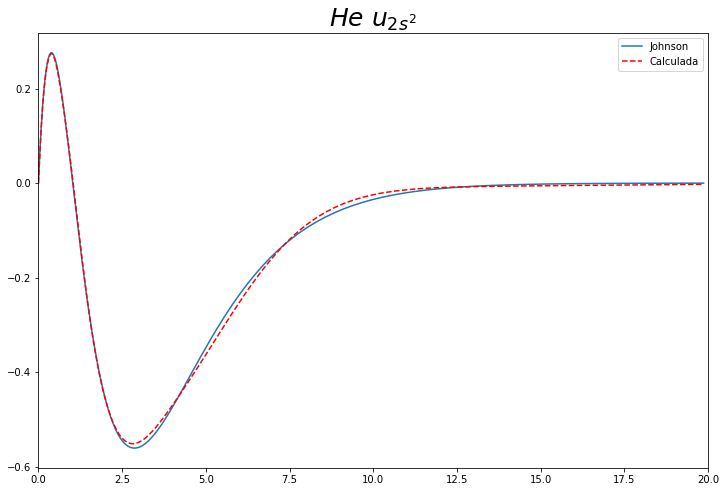

In [488]:
plt.figure(figsize=(12,8))
plt.plot(r,psi_johnson, label = "Johnson")
plt.plot(r,r*psi_calc ,'r--', label = "Calculada")
plt.xlim(rmin,rmax)
plt.title("$He$ $u_{2s^2}$", size=25)
plt.legend(loc='best')

# $H^-$ $1s^2$

In [489]:
# H
#alpha = np.array([0.1219492,0.444529,1.962079,13.00773])

# H- 
alpha = 0.15*np.array([0.298073,1.242567,5.782948,38.474970])

# He
#1s2
#alpha = np.array([0.298073,1.242567,5.782948,38.474970])
#2s2
#alpha = np.array([0.006,0.05, 0.298073, 0.35 ,1.242567,5.782948,38.474970])

# Li+
#alpha = 3*np.array([0.298073,1.242567,5.782948,38.474970])


Z = 1
l = 0

S = Matriz_Overlap(alpha)
C_new = np.random.rand(len(alpha),len(alpha)) #np.ones((len(alpha),len(alpha)))
C_Norm(C_new,S)

H = Matriz_H(alpha,l,Z)
Q = Tensor_Q(alpha)

cont = 0

In [515]:
C = C_new
F = F_Matriz(H,Q,C[:,0])
E, C_new = eigh(F,S,type=1)
C_Norm(C_new,S)
print "Iteracion Nro:", cont
print "-) Energia Total:", Energy_Calc(C_new[:,0],H,Q)
print "-) Energia Ionizacion:", E[0]
cont += 1

Iteracion Nro: 25
-) Energia Total: -0.48480198067427677
-) Energia Ionizacion: -0.037493188508942635


In [516]:
r,psiFunc = np.loadtxt("H_minus_wave.1s",unpack=True)
rmin, rmax = 0, 25
r = r[np.where(r<=rmax)]
psi_johnson = psiFunc[:len(r)]
psi_calc = np.zeros(len(r))
psi_calc = psi(C_new[:,0],alpha,r)

# Normalizo ambas funciones en el intervalo deseado
psi_johnson = psi_johnson/np.trapz((psi_johnson)**2,r)**0.5
psi_calc = psi_calc/np.trapz((r*psi_calc)**2,r)**0.5

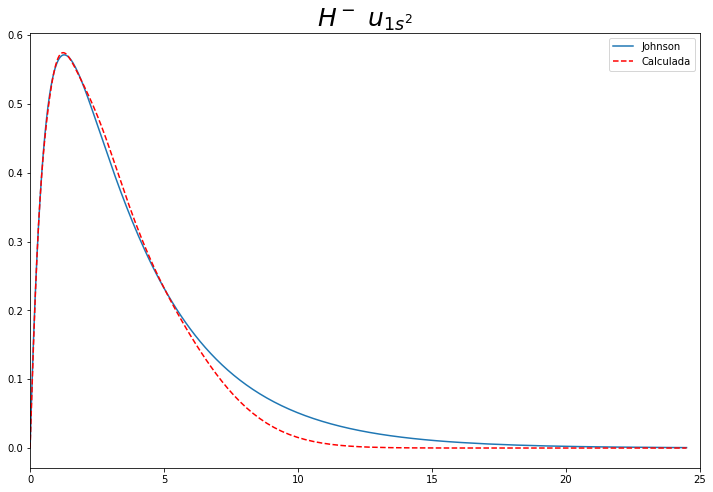

In [517]:
plt.figure(figsize=(12,8))
plt.plot(r,psi_johnson, label = "Johnson")
plt.plot(r,r*psi_calc ,'r--', label = "Calculada")
plt.xlim(rmin,rmax)
plt.title("$H^-$ $u_{1s^2}$", size=25)
plt.legend(loc='best')

- En el caso del $H^-$ podemos ver que el estado no es ligado ya que tenemos energia mayor que la del H, por lo que HF no puede obtener estados ligados para el $H^-$. Esto es asi porque en el calculo del $H^-$ es muy importante tener en cuenta la correlacion que HF no posee.

# Calculo de propiedades quimicas del Na

In [519]:
E_Na0 = -161.85891157
E_NaMenos = -161.85512594
E_NaMas = -161.68228261

Eaff = E_Na0 - E_NaMenos
print aff
Eion = E_NaMas - E_Na0
print Eion

-0.00378563000001
0.17662896


- Me estan dando los signos al reves y no entiendo porque. La energia del orbital en Johnson da -0.181801 y en Fischer 0.3642, asi que seguro estoy metiendo la pata con algo.